In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import pickle
from IPython.display import Image

In [194]:
airports = pd.read_csv('Data/US_airports_geo.csv')

In [195]:
hosts = pd.read_csv('Data/AB_US_2020.csv', low_memory=False)

In [196]:
airports.head()

,IATA,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABQ,Albuquerque International,Albuquerque,NM,USA,35.040222,-106.609194
1,ANC,Ted Stevens Anchorage International,Anchorage,AK,USA,61.174320,-149.996186
2,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,USA,33.640444,-84.426944
3,AUS,Austin-Bergstrom International,Austin,TX,USA,30.194533,-97.669872
4,BDL,Bradley International,Windsor Locks,CT,USA,41.938874,-72.683228


In [197]:
hosts.drop(['host_id', 'host_name', 'neighbourhood_group', 'number_of_reviews', 'last_review','reviews_per_month','calculated_host_listings_count'], inplace=True, axis=1)

In [198]:
hosts.head()

,id,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,28804,35.65146,-82.62792,Private room,60,1,0,Asheville
1,80905,French Chic Loft,28801,35.59779,-82.55540,Entire home/apt,470,1,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,28801,35.60670,-82.55563,Entire home/apt,75,30,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,28806,35.57864,-82.59578,Entire home/apt,90,1,0,Asheville
4,160594,Historic Grove Park,28801,35.61442,-82.54127,Private room,125,30,0,Asheville


In [199]:
airports['category'] = 'Airport'
airports.columns = airports.columns.str.lower()
hosts['category'] = 'Home'

In [200]:
mushed = pd.concat([airports, hosts], ignore_index=True)

### Try K-means, they are distance based.

In [35]:
from sklearn.cluster import KMeans

In [36]:
X_c = mushed[['latitude','longitude']]

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

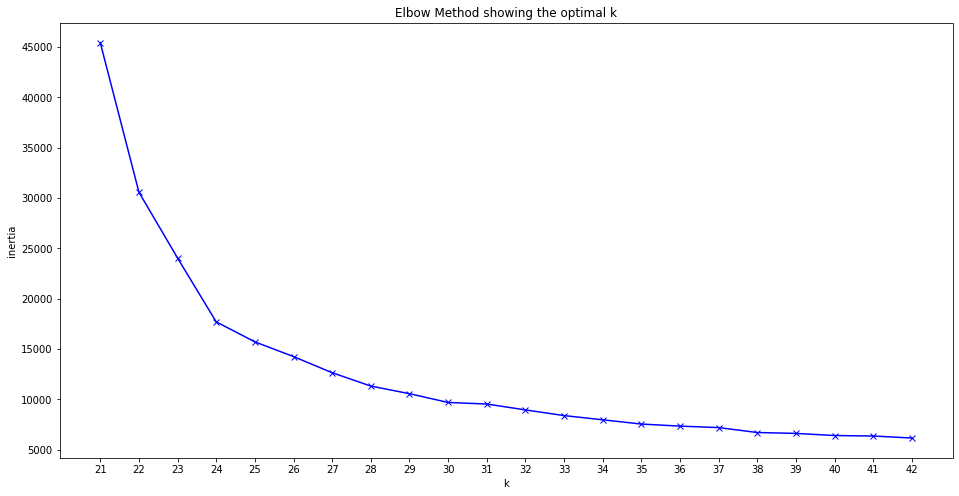

In [37]:
K = range(21, 43)
inertia = []
for k in K:
#     print("Training a K-Means model with {} clusters! ".format(k))
#     print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_c)
    inertia.append(kmeans.inertia_)

    import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [49]:
clusters = KMeans(n_clusters=37, random_state=0).fit(X_c)

In [50]:
mushed['Labels'] = clusters.labels_

In [201]:
mushed.head()

,iata,airport,city,state,country,latitude,longitude,category,id,name,neighbourhood,room_type,price,minimum_nights,availability_365
0,ABQ,Albuquerque International,Albuquerque,NM,USA,35.040222,-106.609194,Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANC,Ted Stevens Anchorage International,Anchorage,AK,USA,61.174320,-149.996186,Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,USA,33.640444,-84.426944,Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AUS,Austin-Bergstrom International,Austin,TX,USA,30.194533,-97.669872,Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BDL,Bradley International,Windsor Locks,CT,USA,41.938874,-72.683228,Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Lets impute the missing values

In [59]:
from sklearn.impute import SimpleImputer

In [63]:
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imp.fit(mushed)

SimpleImputer(strategy='most_frequent')

In [69]:
mush_impd = pd.DataFrame(imp.transform(mushed), columns=mushed.columns)

### Add column with average prices per cluster.

In [73]:
mush_impd['price'] = mush_impd['price'].astype(np.int64)

In [123]:
e =[mush_impd[['price','Labels']].groupby(['Labels']).quantile(0.25)['price'][i] for i in range(37)]
q = {i:j for i,j in zip(range(1,38), e)}

In [167]:
for key,val in q.items():
    mush_impd['q_price'].loc[mush_impd['Labels']==key] = val

/var/folders/gh/lf0mc7p936xfvjr53gs0s95m0000gn/T/ipykernel_8157/704664532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mush_impd['q_price'].loc[mush_impd['Labels']==key] = val


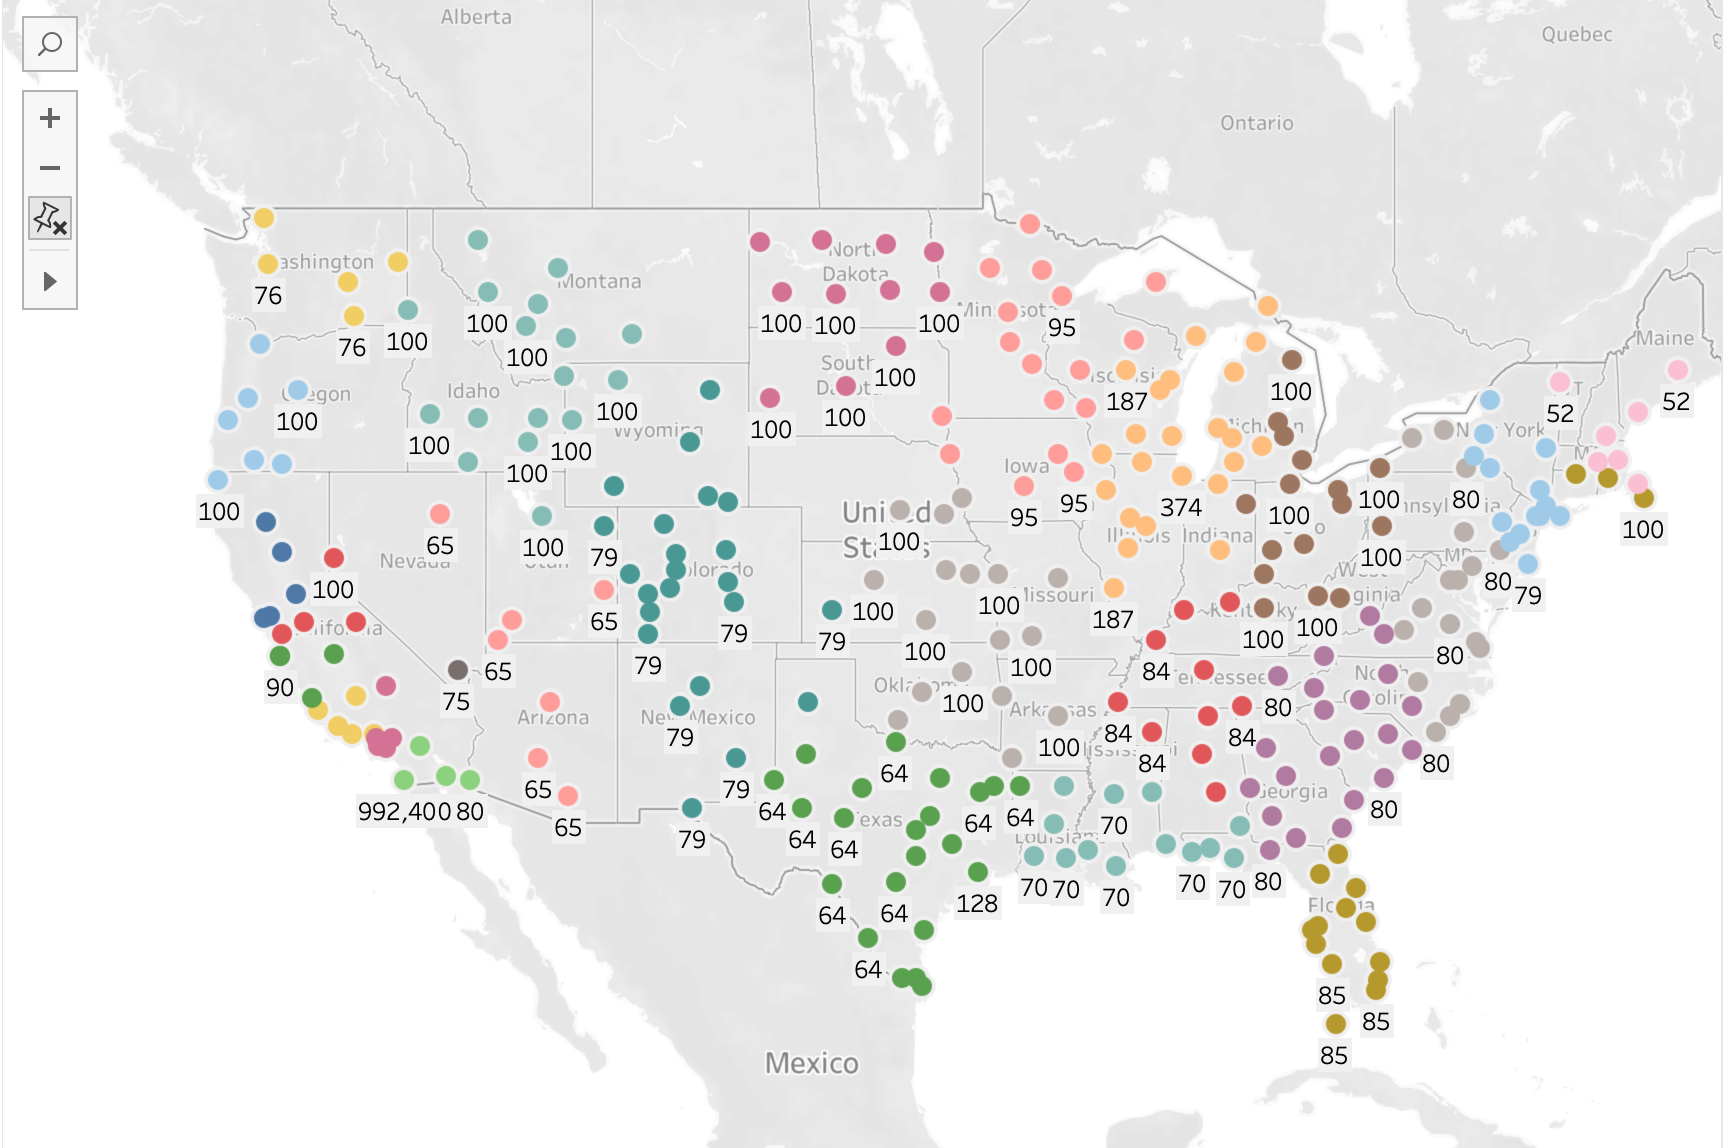

In [183]:
Image(filename='Files/map_2.png')

## Way better, not ideal though..

In [181]:
mush_impd.to_csv('Data/Outputs/mushed.csv')

In [52]:
with open('Files/nn_airports','wb') as file:
    pickle.dump(clusters, file)

### Try and use Pandas superpowers to get the cluster for each airport.

In [220]:
Lat = mushed[['iata', 'price','category', 'latitude']].sort_values('latitude')[mushed['category']=='Airport'].reset_index()

/var/folders/gh/lf0mc7p936xfvjr53gs0s95m0000gn/T/ipykernel_8157/1974863608.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Lat = mushed[['iata', 'price','category', 'latitude']].sort_values('latitude')[mushed['category']=='Airport'].reset_index()


In [221]:
Lon = mushed[['iata', 'price', 'category', 'longitude']].sort_values('longitude')[mushed['category']=='Airport'].reset_index()

/var/folders/gh/lf0mc7p936xfvjr53gs0s95m0000gn/T/ipykernel_8157/2658695740.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Lon = mushed[['iata', 'price', 'category', 'longitude']].sort_values('longitude')[mushed['category']=='Airport'].reset_index()


In [284]:
Lon.longitude = np.abs(Lon.longitude)

In [474]:
n=20
tolerance = 7

In [475]:
neigbours_y = dict()

In [476]:
for i in range(341):
    diff_north = Lon.iloc[:i,:].tail(n).longitude - np.ones(Lon.iloc[:i,:].tail(n).longitude.size)*Lon.iloc[i].longitude
    diff_south = np.ones(Lon.iloc[i:,:].head(n).longitude.size) * Lon.iloc[i].longitude - Lon.iloc[i:,:].head(n).longitude 
    sel_north = Lon.iloc[:i,:].tail(n)
    sel_north.longitude = diff_north
    val = list(sel_north.iata[(sel_north.longitude < tolerance)&(sel_north.longitude!=0)])
    sel_south = Lon.iloc[i:,:].head(n)
    sel_south.longitude = diff_south
    p = list(sel_south.iata[(sel_south.longitude < tolerance)&(sel_south.longitude!=0)])
    val.extend(p)
    key = sel_south[sel_south.longitude==0.0].iata
    neigbours_y.setdefault(list(key)[0], val)

In [477]:
neigbours_x = dict()

In [478]:
for i in range(341):
    diff_west = Lat.iloc[:i,:].tail(n).latitude - np.ones(Lat.iloc[:i,:].tail(n).latitude.size)*Lat.iloc[i].latitude
    diff_east = np.ones(Lat.iloc[i:,:].head(n).latitude.size) * Lat.iloc[i].latitude - Lat.iloc[i:,:].head(n).latitude 
    sel_west = Lat.iloc[:i,:].tail(n)
    sel_west.latitude = diff_west
    val = list(sel_west.iata[(sel_west.latitude < tolerance)&(sel_west.latitude!=0)])
    sel_east = Lat.iloc[i:,:].head(n)
    sel_east.latitude = diff_east
    p = list(sel_east.iata[(sel_east.latitude < tolerance)&(sel_east.latitude!=0)])
    val.extend(p)
    key = sel_east[sel_east.latitude==0.0].iata
    neigbours_x.setdefault(list(key)[0], val)

In [479]:
neighbors = dict()

In [480]:
for key in neigbours_x.keys():
    neighbors[key] = list(set(neigbours_y[key]).intersection(set(neigbours_x[key])))

In [481]:

with open('Data/Outputs/new_clusters', 'wb') as file:
    pickle.dump(neighbors,file)

In [482]:
neighbors

{'GUM': [],
 'PPG': [],
 'SPN': ['BQN', 'STX', 'PSE', 'SJU', 'STT'],
 'STX': ['BQN', 'SPN', 'PSE', 'SJU', 'STT'],
 'PSE': ['BQN', 'SPN', 'STX', 'SJU', 'STT'],
 'STT': ['BQN', 'SPN', 'STX', 'PSE', 'SJU'],
 'SJU': ['BQN', 'SPN', 'STX', 'PSE', 'STT'],
 'BQN': ['SPN', 'STX', 'PSE', 'SJU', 'STT'],
 'ITO': ['KOA', 'LIH', 'OGG', 'HNL'],
 'KOA': ['HNL', 'LIH', 'OGG', 'ITO'],
 'OGG': ['KOA', 'LIH', 'ITO', 'HNL'],
 'HNL': ['KOA', 'LIH', 'OGG', 'ITO'],
 'LIH': ['KOA', 'HNL', 'OGG', 'ITO'],
 'EYW': ['PBI',
  'MIA',
  'GNV',
  'RSW',
  'TPA',
  'MCO',
  'DAB',
  'SRQ',
  'MLB',
  'PIE',
  'FLL'],
 'MIA': ['PBI', 'EYW', 'GNV', 'RSW', 'TPA', 'MCO', 'DAB', 'MLB', 'FLL'],
 'BRO': ['CRP', 'SAT', 'HOU', 'MFE', 'IAH', 'LRD', 'HRL'],
 'FLL': ['PBI', 'EYW', 'MIA', 'GNV', 'RSW', 'MCO', 'DAB', 'MLB'],
 'MFE': ['CRP', 'SAT', 'BRO', 'DRT', 'LRD', 'HRL'],
 'HRL': ['CRP', 'SAT', 'DRT', 'AUS', 'MFE', 'BRO', 'IAH', 'LRD'],
 'RSW': ['PBI',
  'EYW',
  'MIA',
  'GNV',
  'TPA',
  'MCO',
  'DAB',
  'SRQ',
  'MLB',
  'PI